In [9]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)

source("../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

In [ ]:
df_reshuffling <- NULL
for (l in list.files('Reshuffling_intense')){
    if (grepl("_reshuffle_importance.tsv",l)){
        df_tmp <- read.table(paste('Reshuffling_intense/',l,sep=""))
        df_tmp$Ratio <- df_tmp$ref_CI/df_tmp$permuted_CI
        df_tmp <- df_tmp[,c("feature","Ratio","algo","model")]
        df_reshuffling <- rbind(df_reshuffling,df_tmp)     
    }
}

df_bootstrap <- NULL
for (l in list.files('Bootstrap_intense/')){
    if (grepl("_bootstrap",l)){
        if(grepl("_bootstrap_SVM",l)){
            df_tmp <- read.table(paste('Bootstrap_intense/',l,sep=""),sep=',',header=T)
            df_tmp <- df_tmp[,-1]
            df_tmp <- df_tmp[,c(2,1,3)]
        } else {
            df_tmp <- read.table(paste('Bootstrap_intense/',l,sep=""))
        }
        colnames(df_tmp) <- c("feature","sum_coef","num_selected")
        df_tmp$model_algo <- str_sub(l, 1, str_length(l)-4)
        df_bootstrap <- rbind(df_bootstrap,df_tmp)   
    }
}
df_bootstrap <- df_bootstrap[df_bootstrap$feature!="age.1" & !is.na(df_bootstrap$feature),]
df_bootstrap$model <- sub("_bootstrap_.*$", "", df_bootstrap$model_algo )

dim(df_reshuffling)
dim(df_bootstrap)

In [5]:
df_final <- read.table("../clustering/clustering_Final_1/df_final_full_component_ITD.tsv")
master <- read.table("../../data/initial_dataset/Master_04_10_2019.tsv")
rownames(master) <- master$data_pd
df_final <- merge(df_final,master[,c("data_pd","intense")],by=0)
rownames(df_final) <- df_final$Row.names
df_final <- df_final[-1]
df_final$data_pd <- NULL

#Usual Features
eln <- c(2,3,4)
comp <- c(170:193)
age <- c(167)

all_gen <- c(5:88)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- match(names(vect[vect>=2]),names(df_final))
gen_without <- setdiff(gen,grep("^NPM1$", colnames(df_final)))
gen_without <- setdiff(gen_without,grep("^CEBPA_bi$", colnames(df_final))) 
              
all_cyto <- c(89:158)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- match(names(vect[vect>=2]),names(df_final))
cyto_without <- setdiff(cyto,grep("^inv_16$", colnames(df_final)))
cyto_without <- setdiff(cyto_without,grep("^t_8_21$", colnames(df_final)))      
cyto_without <- setdiff(cyto_without,grep("^t_v_11$", colnames(df_final))) 

clin <- c(159:165)
demo <- c(166:167)
demo_without_age <-c(166)
              
name_genes <- colnames(df_final[,gen])
name_cyto <- colnames(df_final[,cyto])
name_comp <- colnames(df_final[,comp])
name_eln <- colnames(df_final[,eln])
for (col in c(name_eln,name_genes,name_cyto,name_comp)){
    df_final[,paste(col,"intense",sep="_")] <- df_final[,col]*df_final$intense
}    
#Features with intensification
    
eln_intense <- c(197:199)
comp_intense <- c(255:278) 
gen_intense <- c(200:234)    
cyto_intense <- c(235:254)
  
eln <- colnames(df_final[,eln])
comp <- colnames(df_final[,comp])  ## be careful with overlap
gen <- colnames(df_final[,gen])
cyto <- colnames(df_final[,cyto])
clin <- colnames(df_final[,clin])
demo <- colnames(df_final[,demo])
eln_intense <- colnames(df_final[,eln_intense])
comp_intense <- colnames(df_final[,comp_intense])
gen_intense <- colnames(df_final[,gen_intense])
cyto_intense <- colnames(df_final[,cyto_intense])

pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",eln_intense="grey45",comp_intense="#000000",gen_intense="#D55E00",cyto_intense="#CC79A7","intense"="#F0E442")    

In [6]:
# Function showing Feature Importance for the Models



importance <- function (models=unique(df_reshuffling$model),fun=median){
    for (model in models){
        set_notebook_plot_size(25,60)
        #Resuflling Importance

        feature_model <- df_reshuffling[df_reshuffling$model==model ,] 
        #%>% filter(str_detect(model, c("0.7|0|1|boost|rfs")))

        feature_model <- feature_model[,c('feature','Ratio','algo')] %>% group_by(feature,algo)  
        #%>% summarize_all(sum)

        feature_model$category <- ifelse(is.element(feature_model$feature,eln),"eln",
                                   ifelse(is.element(feature_model$feature,colnames(df_final[,comp])),"comp",
                                         ifelse(is.element(feature_model$feature,gen),"gen",
                                               ifelse(is.element(feature_model$feature,cyto),"cyto",
                                                     ifelse(is.element(feature_model$feature,clin),"clin", 
                                                         ifelse(is.element(feature_model$feature,eln_intense),"eln_intense",
                                                            ifelse(is.element(feature_model$feature,comp_intense),"comp_intense",
                                                                ifelse(is.element(feature_model$feature,gen_intense),"gen_intense",
                                                                      ifelse(is.element(feature_model$feature,cyto_intense),"cyto_intense",
                                                                             ifelse(is.element(feature_model$feature,"intense"),
                                                                                    "intense","demo"))))))))))

        feature_model$algo <- toupper(feature_model$algo)
        #feature_model$algo <- ifelse(feature_model$algo=="COX","SIMPLE_COX",feature_model$algo)

        # Bootstrapping + Coef Importance

        p <- ggplot(na.omit(feature_model),aes(x=reorder(feature,Ratio,FUN=fun),y=Ratio,fill=category))+geom_boxplot()+facet_wrap(~algo,ncol=6)+
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.text=element_text(size=10),legend.position="top",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=12),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=25))+xlab("Selected Features") +
        ylab("Ratio (ref_CI/Permuted_CI) ") + ggtitle(paste(model, "Model Feature importance Reshuffling"))+coord_flip() +scale_fill_manual(values=pal,limits=names(pal))


        feature_model <- df_bootstrap[startsWith(df_bootstrap$model_algo,paste(model,"_bootstrap_",sep="")) ,] %>% filter(str_detect(model_algo, c("0.7|0|1|boost|rfs|rfx")))

        feature_model <- feature_model[,c('feature','sum_coef','num_selected','model_algo')] %>% group_by(feature,model_algo)  
        #%>% summarize_all(sum)

        feature_model$category <- ifelse(is.element(feature_model$feature,eln),"eln",
                                   ifelse(is.element(feature_model$feature,colnames(df_final[,comp])),"comp",
                                         ifelse(is.element(feature_model$feature,gen),"gen",
                                               ifelse(is.element(feature_model$feature,cyto),"cyto",
                                                     ifelse(is.element(feature_model$feature,clin),"clin", 
                                                         ifelse(is.element(feature_model$feature,eln_intense),"eln_intense",
                                                            ifelse(is.element(feature_model$feature,comp_intense),"comp_intense",
                                                                ifelse(is.element(feature_model$feature,gen_intense),"gen_intense",
                                                                      ifelse(is.element(feature_model$feature,cyto_intense),"cyto_intense",
                                                                             ifelse(is.element(feature_model$feature,"intense"),
                                                                                    "intense","demo"))))))))))

        feature_model$model_algo <- toupper(gsub(".*_bootstrap_", "",feature_model$model_algo ))
        feature_model$model_algo <- ifelse(feature_model$model_algo=="GLM_0","RIDGE",
                                          ifelse(feature_model$model_algo=="GLM_0.7","ELASTIC_NET",
                                                ifelse(feature_model$model_algo=="GLM_1","LASSO",feature_model$model_algo)))

        q <- ggplot(na.omit(feature_model %>% filter(str_detect(model_algo, c("LASSO|RIDGE|ELASTIC_NET|BOOST|RFS|RFX")))),aes(x=reorder(feature,num_selected,FUN=mean),y=num_selected,fill=category))+geom_bar(stat = "identity")+facet_wrap(~model_algo,ncol=6)+
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.text=element_text(size=10),legend.position="top",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=12),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=25))+xlab("Selected Features") +
        ylab("Proportion of selection count overall models and algorithms ") + ggtitle(paste(model, "Model Feature importance Bootstrap for Algorithms"))+coord_flip() +scale_fill_manual(values=pal,limits=names(pal))

        r <-  ggplot(na.omit(feature_model %>% filter(str_detect(model_algo, c("LASSO|RIDGE|ELASTIC_NET")))),aes(x=reorder(feature,sum_coef),y=sum_coef,fill=category))+geom_bar(stat = "identity")+facet_wrap(~model_algo,ncol=5)+
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.text=element_text(size=10),legend.position="top",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=12),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=25))+xlab("Selected Features") +
        ylab("Sum of coefficients over GLM Models ") + ggtitle(paste(model, "Coefficients for Cox Penalized Models"))+coord_flip() +scale_fill_manual(values=pal,limits=names(pal))

        grid.arrange(p,q,r,nrow=3)


    }
}

# Overall Curves

In [139]:
set_notebook_plot_size(20,10)
# pdf("../graphs/Intensification/KM_curves_overall_and_age.pdf",width=20,height=10)
plot_intense <- function(tmp,fit,strat="all",leg.labs="",y="",pval){
    

    
    p <- ggsurvplot(fit,  pval = pval,pval.coord=c(0,0.05),pval.size=8,
                         risk.table=F,submain = paste("Intensification effect for ",strat,sep=""),palette=c("#EE9937","#5C5C5C","#009E73","#0072B2"),legend.labs=leg.labs,risk.table.col = "strata",legend="top",legend.title="",
                        ,risk.table.fontsize=10,xlab="Time (years)",ylab=y,
               linetype=1,size=4,
                  ggtheme = theme_survminer(
                 font.main = c(60, "bold", "black"),
                 font.submain = c(30, "bold.italic", "black"),
                 font.legend=25,
                 font.caption = c(30, "plain", "black"),
                 font.x = c(30, "bold.italic", "black"),
                 font.y = c(30, "bold.italic", "black"),
                 font.tickslab = c(30, "plain", "black")))
    p$plot
}





# dev.off()

In [92]:
# png("")
tmp <- df_final
tmp$comparison <- ifelse(tmp$intense==1,"intense","no_intense")
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- ggplot(tmp,aes(reorder(comparison,comparison,function(x)-length(x)),fill=comparison))+geom_bar()+scale_fill_manual(values=c("#EE9937","#5C5C5C"))+guides(fill=F)+
theme(plot.title = element_text(hjust = 0.5,size=65,face="bold"),axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),axis.title.y=element_text(size=30,face="bold"))+xlab("")+ylab("Count")
q <- plot_intense(tmp,pval=T,fit,strat="ALL",y="Survival Probability",leg.labs=c(paste("intense",nrow(tmp[(tmp$intense==1),]),sep=", n="),paste("no_intense",nrow(tmp[(tmp$intense==0),]),sep=", n=")))


png("Intense_all.png",width=10000,height=2500,res=200)
grid.arrange(p,q$plot,ncol=2)
dev.off()


pdf 
  2

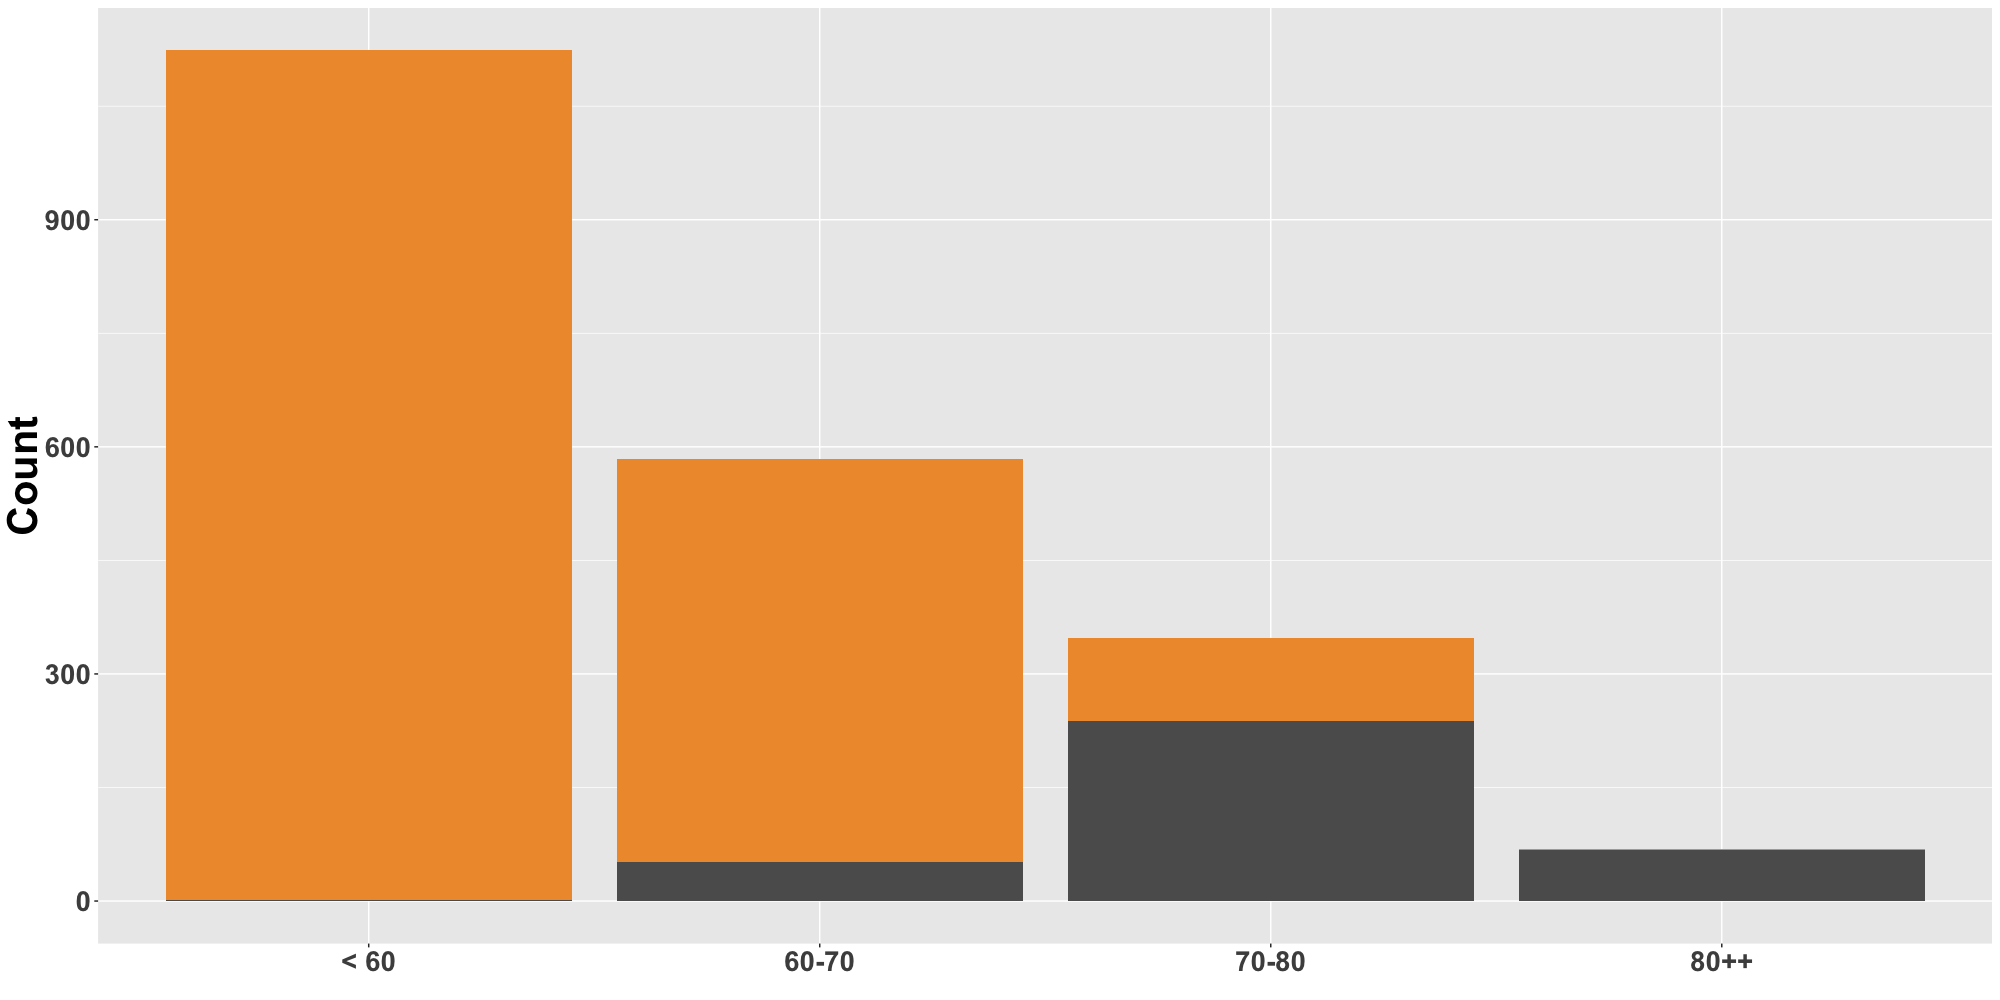

In [111]:
tmp <- df_final
tmp$comparison <- ifelse(tmp$age <60,"< 60",
                        ifelse(tmp$age >=60 & tmp$age<70,"60-70",
                              ifelse(tmp$age >=70 & tmp$age<80,"70-80","80++")))
tmp$intense <- ifelse(tmp$intense==0,"no_intense","intense")
# ggplot(tmp,aes(x=comparison))+geom_bar(aes(fill=intense))
ggplot(tmp,aes(reorder(x=comparison,comparison,function(x)-length(x))))+geom_bar(aes(fill=intense))+scale_fill_manual(values=c("#EE9937","#5C5C5C","#870C14","#BFBFBF"))+guides(fill=F)+
theme(plot.title = element_text(hjust = 0.5,size=65,face="bold"),legend.text = element_text(size=10),
      axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),axis.title.y=element_text(size=30,face="bold"))+xlab("")+ylab("Count")


# Component Curves

In [131]:
co <- "full_component_additions"
tmp <- df_final
tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste(str_replace(co,"full_component_",""),"_intense",sep=""),
                     ifelse(tmp$intense==0 & tmp[,co]==1,paste(str_replace(co,"full_component_",""),"_no_intense",sep=""),
                         ifelse(tmp$intense==0 & tmp[,co]==0,"_others_no_intense","_others_intense")))
table(tmp$comparison)


     _others_intense   _others_no_intense    additions_intense 
                1626                  307                  141 
additions_no_intense 
                  51 

In [142]:
df_final_no_ITD <- read.table("../clustering/clustering_Final_1/df_final_full_component.tsv")
comp <- colnames(df_final_no_ITD[,c(170:186)])


In [ ]:
# BENEFITING :

In [164]:
set_notebook_plot_size(30,7)
p <- list()
# for (co in c("full_component_t_8_21","full_component_t_11","full_component_NPM1")){
for (co in c("full_component_TP53_complex","full_component_WT1","full_component_chr_splicing_multiple","overlap")){
    tmp <- df_final
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste(str_replace(co,"full_component_",""),"_intense",sep=""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste(str_replace(co,"full_component_",""),"_no_intense",sep=""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"_others_no_intense","_others_intense")))

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value

    ##
        
#     p[[co]] <-try(plot(plot_intense(tmp,pval=T,fit,strat=co,y="Survival Probability",leg.labs=c(paste("others_intense",nrow(tmp[(tmp$comparison=="_others_intense"),]),sep=", n="),
    
     p[[co]] <-try((plot_intense(tmp,pval=T,fit,strat=str_replace(co,"full_component_",""),y="Survival Probability",leg.labs=c(paste("others_intense",nrow(tmp[(tmp$comparison=="_others_intense"),]),sep=", n="),
                                                                                                 paste("others_no_intense",nrow(tmp[(tmp$comparison=="_others_no_intense"),]),sep=", n="),
                                                    paste(paste(str_replace(co,"full_component_",""),"_intense",sep=""),nrow(tmp[(tmp$comparison==paste(str_replace(co,"full_component_",""),"_intense",sep="")),]),sep=", n="),
                                                    paste(paste(str_replace(co,"full_component_",""),"_no_intense",sep=""),nrow(tmp[(tmp$comparison==paste(str_replace(co,"full_component_",""),"_no_intense",sep="")),]),sep=", n=")                            
                                                                               ))))
    
    }
png("comp_NOT_benefit_intense.png",width=6000,height=4160,res=200)
grid.arrange(p[["full_component_TP53_complex"]],p[["full_component_WT1"]],p[["full_component_chr_splicing_multiple"]],p[["overlap"]],nrow=4)
dev.off()

pdf 
  2

# Genes and cyto Curves

In [170]:
table(tmp$full_component_chr_splicing_multiple,tmp$intense)

   
       0    1
  0  212 1457
  1  146  310

In [177]:
# for (co in c("CEBPA_mono","RAD21","NPM1","t_8_21")){
for (co in c("ASXL1","RUNX1","SF3B1","SRSF2","TP53","complex")){
    tmp <- df_final
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste(str_replace(co,"full_component_",""),"_intense",sep=""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste(str_replace(co,"full_component_",""),"_no_intense",sep=""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"_others_no_intense","_others_intense")))

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value

    ##
        
#     p[[co]] <-try(plot(plot_intense(tmp,pval=T,fit,strat=co,y="Survival Probability",leg.labs=c(paste("others_intense",nrow(tmp[(tmp$comparison=="_others_intense"),]),sep=", n="),
    
     p[[co]] <-try((plot_intense(tmp,pval=T,fit,strat=str_replace(co,"full_component_",""),y="Survival Probability",leg.labs=c(paste("others_intense",nrow(tmp[(tmp$comparison=="_others_intense"),]),sep=", n="),
                                                                                                 paste("others_no_intense",nrow(tmp[(tmp$comparison=="_others_no_intense"),]),sep=", n="),
                                                    paste(paste(str_replace(co,"full_component_",""),"_intense",sep=""),nrow(tmp[(tmp$comparison==paste(str_replace(co,"full_component_",""),"_intense",sep="")),]),sep=", n="),
                                                    paste(paste(str_replace(co,"full_component_",""),"_no_intense",sep=""),nrow(tmp[(tmp$comparison==paste(str_replace(co,"full_component_",""),"_no_intense",sep="")),]),sep=", n=")                            
                                                                               ))))
    
    }
png("gen_cyto_NOT_benefit_intense.png",width=4000,height=6250,res=200)
grid.arrange(p[["ASXL1"]],p[["RUNX1"]],p[["SF3B1"]],p[["SRSF2"]],p[["TP53"]],p[["complex"]],nrow=6)
dev.off()

pdf 
  2

# Interesting Components Curves

In [99]:
set_notebook_plot_size(30,7)
pdf("../graphs/Intensification/KM_curves_interesting_comp.pdf",width=30,height=7)
for (co in c("full_component_t_8_21", "full_component_NPM1" ,"full_component_NPM1_ITD" , "full_component_chr_splicing_1")){
    tmp <- df_final[df_final$age<=60,]
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste("_",paste(co,"_intense",sep=""),""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste("_",paste(co,"_no_intense",sep=""),""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"wt_no_intense","wt_intense")))
    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value
    m <- "no pvalue"
    res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp)
    try(if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] <0.0001){
        m <- paste("p <0.0001")
    }else if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] >0.0001){
        m <- paste("p = ",round(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")],4),sep="")
    }else {m <- "no pvalue"})
    ##
        
    p <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),main = "Survival curve ",risk.table=T,submain = "Kaplan-Meier estimates intensification stratification <=60",palette=c("#EE9937","#5C5C5C","#59A08B","#2b8cbe"),linetype=c(1,1,rep(3,16),1),
                      ggtheme = theme_survminer(
                     font.main = c(16, "bold", "darkblue"),
                     font.submain = c(15, "bold.italic", "purple"),
                     font.caption = c(14, "plain", "orange"),
                     font.x = c(14, "bold.italic", "red"),
                     font.y = c(14, "bold.italic", "darkred"),
                     font.tickslab = c(12, "plain", "darkgreen")))
    tmp <- df_final[df_final$age>60,]
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste("_",paste(co,"_intense",sep=""),""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste("_",paste(co,"_no_intense",sep=""),""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"wt_no_intense","wt_intense")))

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value
    m <- "no pvalue"
    res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp)
    try(if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] <0.0001){
        m <- paste("p <0.0001")
    }else if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] >0.0001){
        m <- paste("p = ",round(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")],4),sep="")
    }else {m <- "no pvalue"})
    ##
    
    q <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),main = "Survival curve ",risk.table=T,submain = "Kaplan-Meier estimates intensification stratification >60",palette=c("#EE9937","#5C5C5C","#59A08B","#2b8cbe"),linetype=c(1,1,rep(3,16),1),
                      ggtheme = theme_survminer(
                     font.main = c(16, "bold", "darkblue"),
                     font.submain = c(15, "bold.italic", "purple"),
                     font.caption = c(14, "plain", "orange"),
                     font.x = c(14, "bold.italic", "red"),
                     font.y = c(14, "bold.italic", "darkred"),
                     font.tickslab = c(12, "plain", "darkgreen")))
    arrange_ggsurvplots(list(p,q),ncol=2)
    }
dev.off()

Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds


pdf 
  2

# Genes and Cyto Curves

In [75]:
set_notebook_plot_size(30,7)
pdf("../graphs/Intensification/KM_curves_gen_cyto.pdf",width=30,height=7)

for (co in c(gen,cyto)){
    tmp <- df_final[df_final$age<=60,]
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste("_",paste(co,"_intense",sep=""),""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste("_",paste(co,"_no_intense",sep=""),""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"wt_no_intense","wt_intense")))
    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value
    m <- "no pvalue"
    res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp)
    try(if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] <0.0001){
        m <- paste("p <0.0001")
    }else if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] >0.0001){
        m <- paste("p = ",round(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")],4),sep="")
    }else {m <- "no pvalue"})
    ##
        
    p <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),main = "Survival curve ",risk.table=T,submain = "Kaplan-Meier estimates intensification stratification <=60",palette=c("#EE9937","#5C5C5C","#59A08B","#2b8cbe"),linetype=c(1,1,rep(3,16),1),
                      ggtheme = theme_survminer(
                     font.main = c(16, "bold", "darkblue"),
                     font.submain = c(15, "bold.italic", "purple"),
                     font.caption = c(14, "plain", "orange"),
                     font.x = c(14, "bold.italic", "red"),
                     font.y = c(14, "bold.italic", "darkred"),
                     font.tickslab = c(12, "plain", "darkgreen")))
    tmp <- df_final[df_final$age>60,]
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste("_",paste(co,"_intense",sep=""),""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste("_",paste(co,"_no_intense",sep=""),""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"wt_no_intense","wt_intense")))

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value
    m <- "no pvalue"
    res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp)
    try(if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] <0.0001){
        m <- paste("p <0.0001")
    }else if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] >0.0001){
        m <- paste("p = ",round(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")],4),sep="")
    }else {m <- "no pvalue"})
    ##
    
    q <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),main = "Survival curve ",risk.table=T,submain = "Kaplan-Meier estimates intensification stratification >60",palette=c("#EE9937","#5C5C5C","#59A08B","#2b8cbe"),linetype=c(1,1,rep(3,16),1),
                      ggtheme = theme_survminer(
                     font.main = c(16, "bold", "darkblue"),
                     font.submain = c(15, "bold.italic", "purple"),
                     font.caption = c(14, "plain", "orange"),
                     font.x = c(14, "bold.italic", "red"),
                     font.y = c(14, "bold.italic", "darkred"),
                     font.tickslab = c(12, "plain", "darkgreen")))
    arrange_ggsurvplots(list(p,q),ncol=2)
    }
dev.off()

Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""), 

pdf 
  2

# Interesting Genes and Cytos Curves

In [84]:
set_notebook_plot_size(30,7)
pdf("../graphs/Intensification/KM_curves_interesting_gen_cyto_benefiting.pdf",width=30,height=7)

for (co in c("CEBPA_mono","IDH1","IDH2_p.R140","KIT","NPM1","SMC3","t_8_21")){
    tmp <- df_final[df_final$age<=60,]
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste("_",paste(co,"_intense",sep=""),""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste("_",paste(co,"_no_intense",sep=""),""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"wt_no_intense","wt_intense")))
    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value
    m <- "no pvalue"
    res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp)
    try(if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] <0.0001){
        m <- paste("p <0.0001")
    }else if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] >0.0001){
        m <- paste("p = ",round(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")],4),sep="")
    }else {m <- "no pvalue"})
    ##
        
    p <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),main = "Survival curve ",risk.table=T,submain = "Kaplan-Meier estimates intensification stratification <=60",palette=c("#EE9937","#5C5C5C","#59A08B","#2b8cbe"),linetype=c(1,1,rep(3,16),1),
                      ggtheme = theme_survminer(
                     font.main = c(16, "bold", "darkblue"),
                     font.submain = c(15, "bold.italic", "purple"),
                     font.caption = c(14, "plain", "orange"),
                     font.x = c(14, "bold.italic", "red"),
                     font.y = c(14, "bold.italic", "darkred"),
                     font.tickslab = c(12, "plain", "darkgreen")))
    tmp <- df_final[df_final$age>60,]
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste("_",paste(co,"_intense",sep=""),""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste("_",paste(co,"_no_intense",sep=""),""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"wt_no_intense","wt_intense")))

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value
    m <- "no pvalue"
    res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp)
    try(if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] <0.0001){
        m <- paste("p <0.0001")
    }else if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] >0.0001){
        m <- paste("p = ",round(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")],4),sep="")
    }else {m <- "no pvalue"})
    ##
    
    q <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),main = "Survival curve ",risk.table=T,submain = "Kaplan-Meier estimates intensification stratification >60",palette=c("#EE9937","#5C5C5C","#59A08B","#2b8cbe"),linetype=c(1,1,rep(3,16),1),
                      ggtheme = theme_survminer(
                     font.main = c(16, "bold", "darkblue"),
                     font.submain = c(15, "bold.italic", "purple"),
                     font.caption = c(14, "plain", "orange"),
                     font.x = c(14, "bold.italic", "red"),
                     font.y = c(14, "bold.italic", "darkred"),
                     font.tickslab = c(12, "plain", "darkgreen")))
    arrange_ggsurvplots(list(p,q),ncol=2)
    }
dev.off()
        
pdf("../graphs/Intensification/KM_curves_interesting_gen_cyto_NOT_benefiting.pdf",width=30,height=7)       
for (co in c("CEBPA_bi","del_16","add_22","add_11","MYC")){
    tmp <- df_final[df_final$age<=60,]
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste("_",paste(co,"_intense",sep=""),""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste("_",paste(co,"_no_intense",sep=""),""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"wt_no_intense","wt_intense")))
    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value
    m <- "no pvalue"
    res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp)
    try(if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] <0.0001){
        m <- paste("p <0.0001")
    }else if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] >0.0001){
        m <- paste("p = ",round(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")],4),sep="")
    }else {m <- "no pvalue"})
    ##
        
    p <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),main = "Survival curve ",risk.table=T,submain = "Kaplan-Meier estimates intensification stratification <=60",palette=c("#EE9937","#5C5C5C","#59A08B","#2b8cbe"),linetype=c(1,1,rep(3,16),1),
                      ggtheme = theme_survminer(
                     font.main = c(16, "bold", "darkblue"),
                     font.submain = c(15, "bold.italic", "purple"),
                     font.caption = c(14, "plain", "orange"),
                     font.x = c(14, "bold.italic", "red"),
                     font.y = c(14, "bold.italic", "darkred"),
                     font.tickslab = c(12, "plain", "darkgreen")))
    tmp <- df_final[df_final$age>60,]
    tmp$comparison <- ifelse(tmp$intense==1 & tmp[,co]==1,paste("_",paste(co,"_intense",sep=""),""),
                         ifelse(tmp$intense==0 & tmp[,co]==1,paste("_",paste(co,"_no_intense",sep=""),""),
                             ifelse(tmp$intense==0 & tmp[,co]==0,"wt_no_intense","wt_intense")))

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    
    ## specific p value
    m <- "no pvalue"
    res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp)
    try(if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] <0.0001){
        m <- paste("p <0.0001")
    }else if(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")] >0.0001){
        m <- paste("p = ",round(res$p.value[paste("_",paste(co,"_no_intense",sep=""),""),paste("_",paste(co,"_intense",sep=""),"")],4),sep="")
    }else {m <- "no pvalue"})
    ##
    
    q <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),main = "Survival curve ",risk.table=T,submain = "Kaplan-Meier estimates intensification stratification >60",palette=c("#EE9937","#5C5C5C","#59A08B","#2b8cbe"),linetype=c(1,1,rep(3,16),1),
                      ggtheme = theme_survminer(
                     font.main = c(16, "bold", "darkblue"),
                     font.submain = c(15, "bold.italic", "purple"),
                     font.caption = c(14, "plain", "orange"),
                     font.x = c(14, "bold.italic", "red"),
                     font.y = c(14, "bold.italic", "darkred"),
                     font.tickslab = c(12, "plain", "darkgreen")))
    arrange_ggsurvplots(list(p,q),ncol=2)
    }
dev.off()

Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds


pdf 
  2

Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds
Error in res$p.value[paste("_", paste(co, "_no_intense", sep = ""), ""),  : 
  subscript out of bounds


pdf 
  2

# Specific Models

In [85]:
pdf("../graphs/Intensification/importance_intensification_by_model.pdf",width=25,height=60)
importance(c("gen_gen_intense","cyto_cyto_intense","comp_comp_intense","gen_cyto_gen_intense_cyto_intense","eln_eln_intense","eln_comp_gen_cyto_eln_intense_comp_intense_gen_intense_cyto_intense","comp_intense_gen_intense_cyto_intense"))
dev.off()

pdf 
  2

# All Models

In [86]:
pdf("../graphs/Intensification/importance_intensification_all_models.pdf",width=25,height=60)
importance()
dev.off()

pdf 
  2

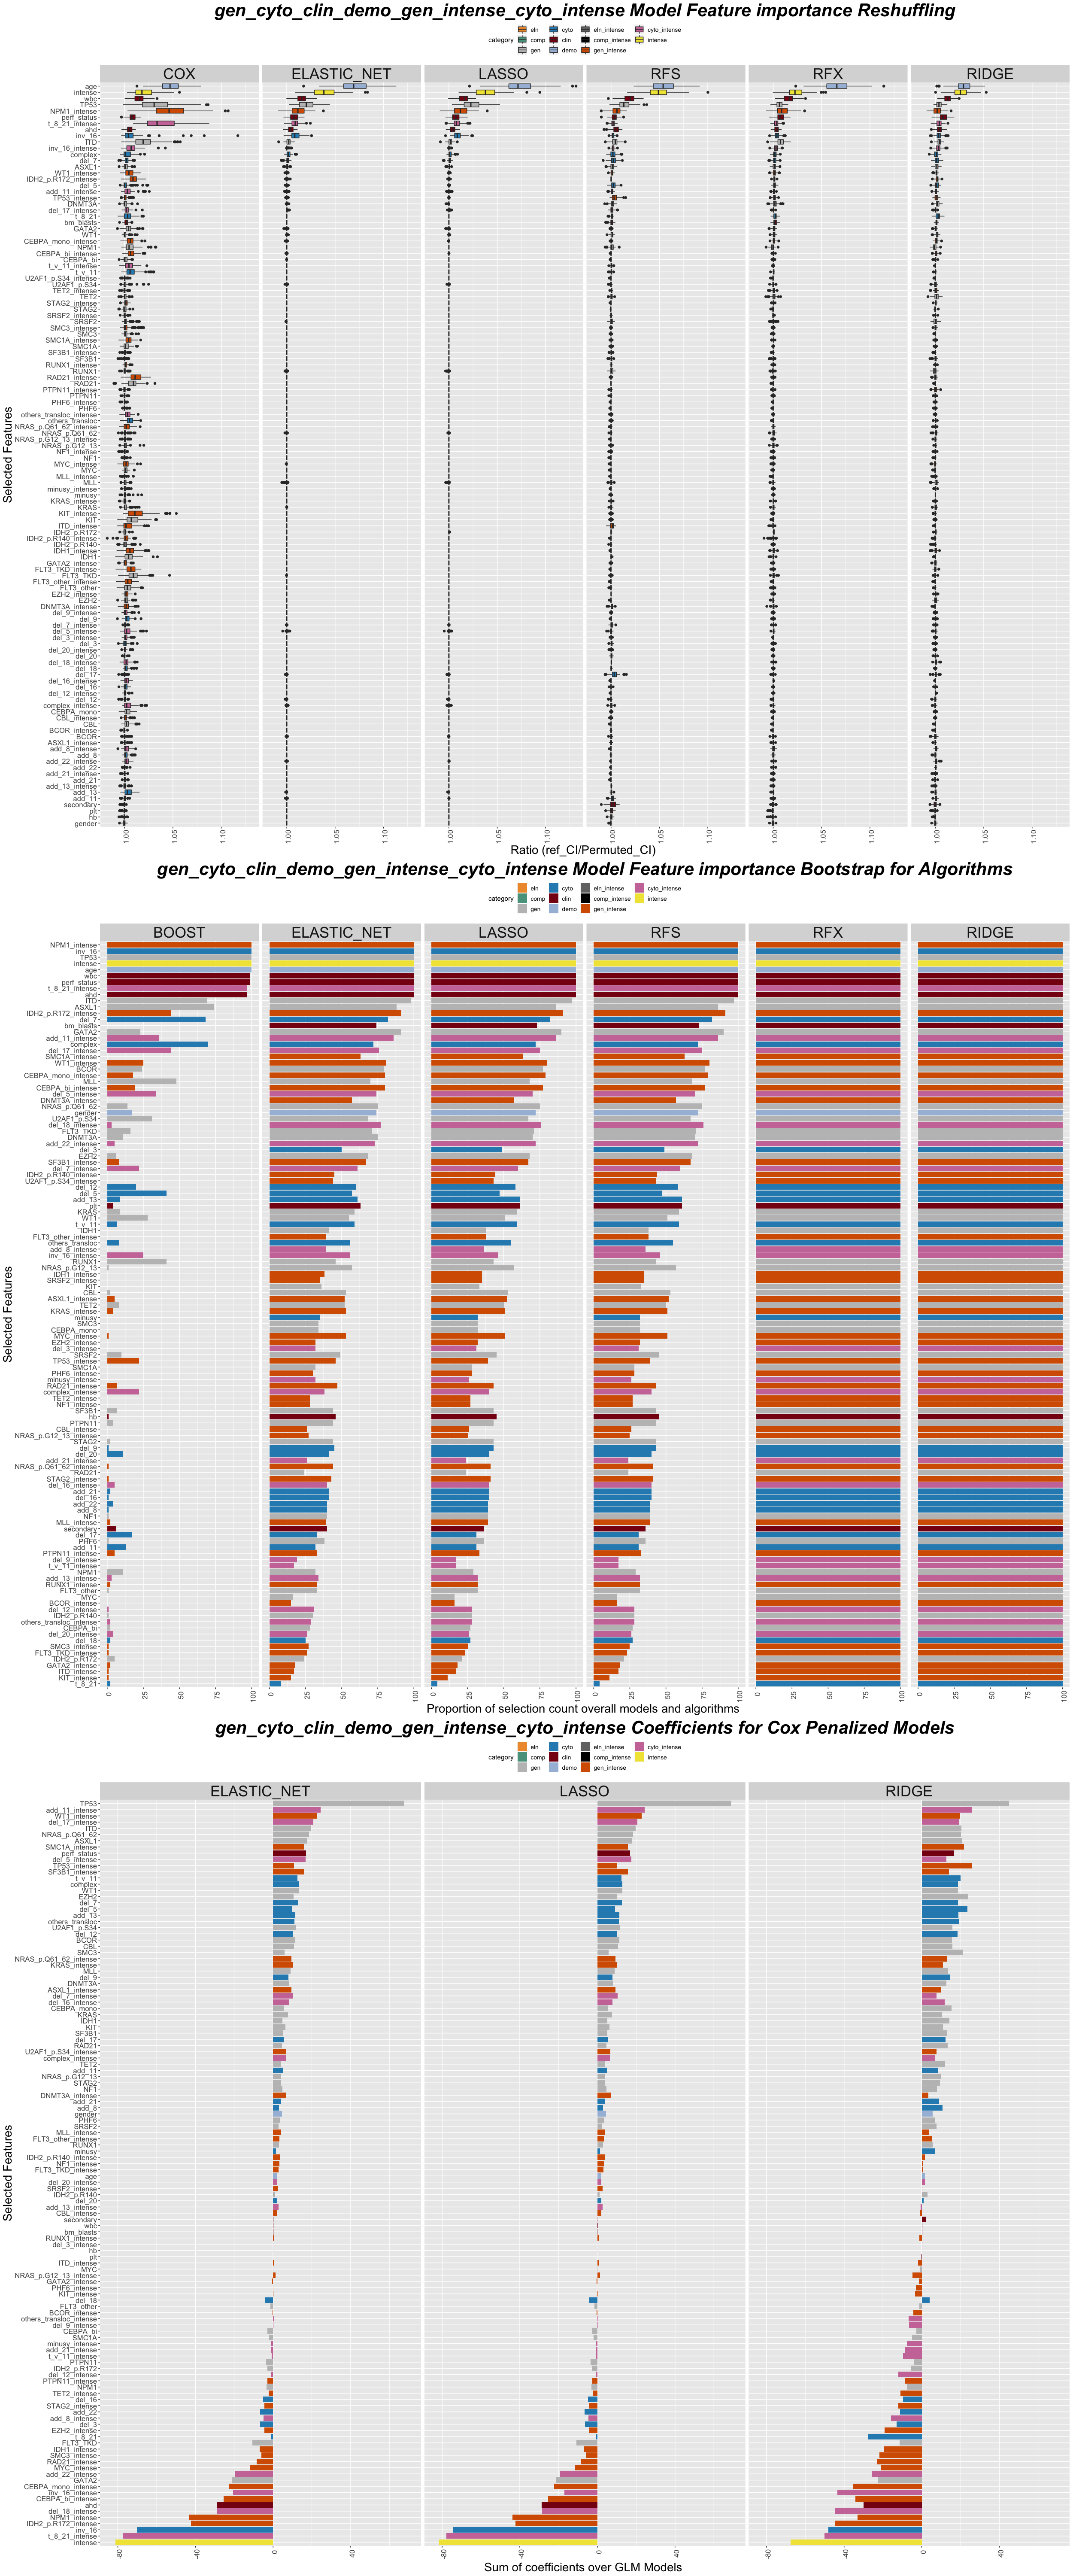

In [89]:
importance(c("gen_cyto_clin_demo_gen_intense_cyto_intense"))

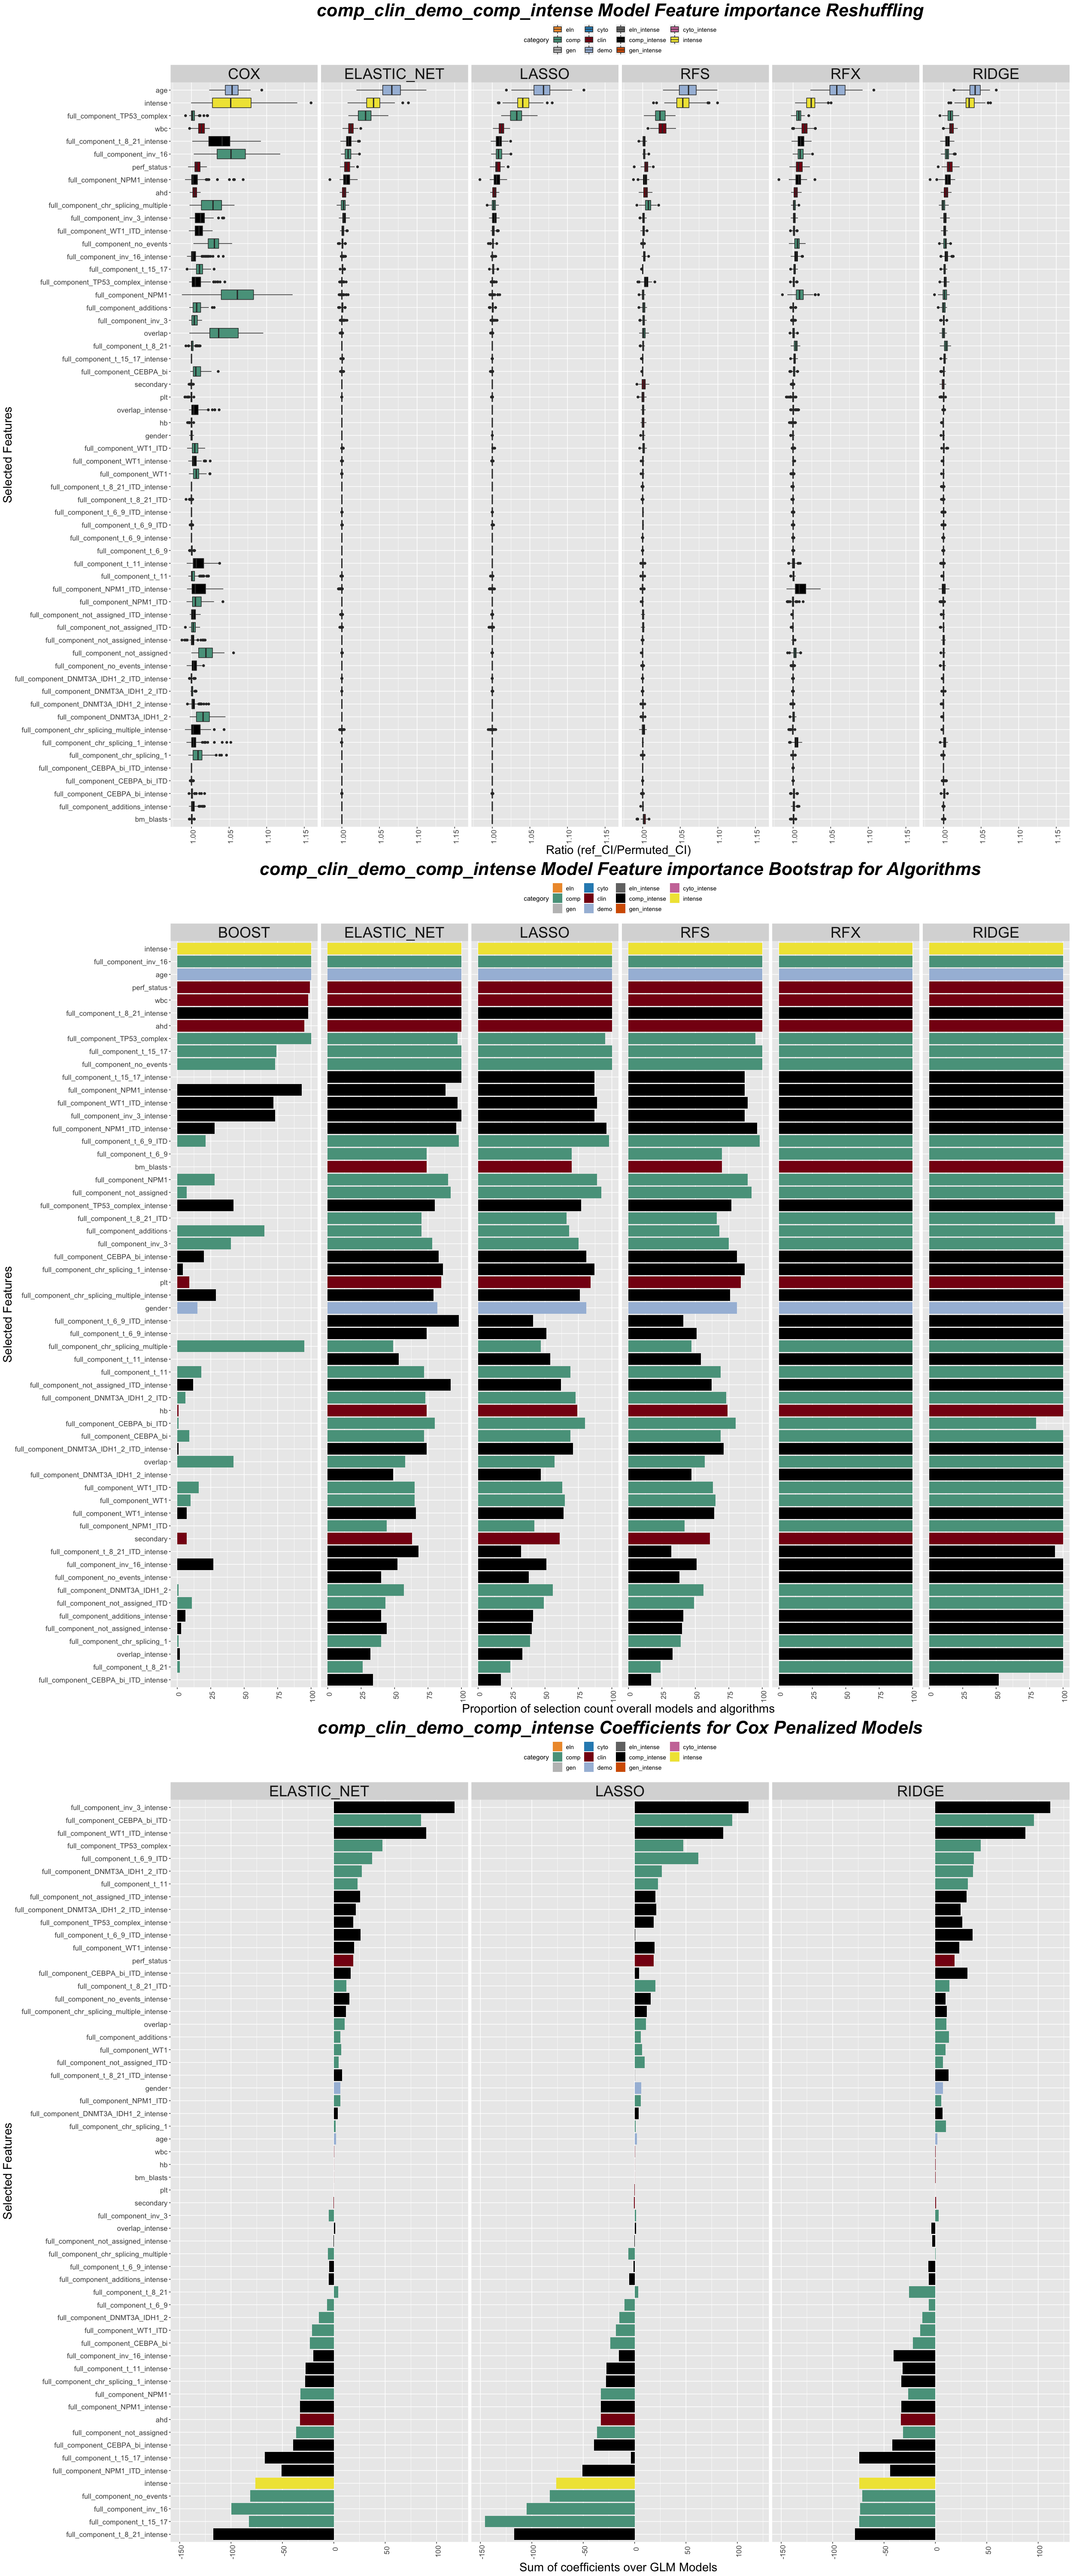

In [90]:
importance(c("comp_clin_demo_comp_intense"))